In [1]:
import nltk
# nltk.download()
# import matplotlib.pyplot as plt

In [2]:
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
import re

def leaves(tree):
    """Finds NP (nounphrase) leaf nodes of a chunk tree."""
    for subtree in tree.subtrees(filter = lambda t: t.label()=='NP'):
       # The yield statement suspends function’s execution and sends a value back to the caller.
        yield subtree.leaves()

def acceptable_word(word):
    """Checks conditions for acceptable word: length, stopword."""
    accepted = bool(2 <= len(word) <= 40
                    and word.lower() not in stopwords)
    return accepted

def get_terms(tree):

    for leaf in leaves(tree):
        term = [ w for w,t in leaf if acceptable_word(w) ]
        yield term


In [3]:
grammar =r"""
  NP: {<DT|JJ|NN.*>+}          
  PP: {<IN><NP>}            
  VP: {<VB.*><NP|PP|CLAUSE>+$}
  CLAUSE: {<NP><VP>}          
  """
      

In [4]:
def phrase_extraction(text, grammar):
    text = text.lower()
    sentence_re = r'''(?x)          
      (?:[A-Z]\.)+        
    | \w+(?:-\w+)*        
    | \$?\d+(?:\.\d+)?%?  
    | \.\.\.              
    | [][.,;"'?():_`-]    
    '''
    
    ls = [] 
    word_token_ls = text.split(" ")

    toks = nltk.regexp_tokenize(text, sentence_re)
    postoks = nltk.tag.pos_tag(toks)
    
    chunker = nltk.RegexpParser(grammar)
    
    tree = chunker.parse(postoks)
    terms = get_terms(tree)
    for term in terms:
        ls.append(" ".join(term)) 
    return list(set(ls))



In [5]:
import pandas as pd
import numpy as np
import glob

In [6]:
# select/read all files
all_files=glob.glob("/Users/tanyachauhan/Documents/Diksha_last3month_content_review"+"/*.csv")

# List of Dataframe of all files
dflist = []


In [7]:
for filename in all_files:
    
    # Dataframe of one file
    df = pd.read_csv(filename, index_col=None, header=0)

    dflist.append(df)


In [8]:
frame = pd.concat(dflist, axis=0, ignore_index=True)
frame

,edata_rating,edata_comments,object_id,@timestamp
0,1,R,do_31251881421707673619722,2019-12-15T10:23:41.418Z
1,1,couldn't load the lesson,do_31291802222771404811686,2019-12-27T16:03:59.483Z
2,1,V,do_31291802222771404811686,2019-12-29T07:54:48.654Z
3,1,��࣮�ಮ࿮�,do_31279841742245068814937,2019-12-30T10:21:49.864Z
4,5,4,do_31291815697734041611830,2019-12-31T17:31:11.872Z
...,...,...,...,...
391,5,,do_31266761534688460812969,2020-02-27T09:03:28.095Z
392,5,r,do_31251881765774131219724,2020-02-27T13:08:44.747Z
393,3,r,do_31266761534688460812969,2020-02-28T08:14:08.709Z
394,5,good,do_31251881765774131219724,2020-02-28T09:07:52.731Z


In [9]:
# frame.sort_values("edata_rating", axis = 0, ascending = True, 
#                  inplace = True, na_position ='last')
# frame

In [10]:
# replace NaN value with space(easy for further evaluation)
from numpy import nan
frame = frame.replace(np.nan, '', regex=True)


In [11]:
# creating a list of review text column
review_ls = list(frame["edata_comments"])  
print(type(review_ls))

<class 'list'>


In [12]:
#Creating a new Dtaframe which is required for final csv
new_dataframe = pd.DataFrame(columns=['edata_comments', 'Keywords'])

for i in review_ls:
    if(i==''):
        new_dataframe = new_dataframe.append({'edata_comments': i, 'Keywords': '[]'}, ignore_index=True)
    else:
        x=phrase_extraction(i, grammar)
        new_dataframe = new_dataframe.append({'edata_comments': i, 'Keywords': x}, ignore_index=True)

new_dataframe

,edata_comments,Keywords
0,R,[]
1,couldn't load the lesson,"[, lesson]"
2,V,[]
3,��࣮�ಮ࿮�,[]
4,4,[]
...,...,...
391,,[]
392,r,[]
393,r,[]
394,good,[good]


In [13]:
# Sentiment Analysis
from textblob import TextBlob

# List of sentiments of each review text
sentiments = []

for i in review_ls:
    blob = TextBlob(str(i))
    s = blob.sentiment
    sentiments.append(s)
    
#print(sentiments)

In [14]:
# Creating a dataframe of sentiments
sentiment = pd.DataFrame(sentiments)
sentiment

,polarity,subjectivity
0,0.0,0.0
1,0.0,0.0
2,0.0,0.0
3,0.0,0.0
4,0.0,0.0
...,...,...
391,0.0,0.0
392,0.0,0.0
393,0.0,0.0
394,0.7,0.6


In [15]:
new_dataframe.insert(2,"object_id",frame["object_id"])

In [16]:
new_dataframe.insert(3,"edata_rating",frame["edata_rating"])

In [17]:
new_dataframe.insert(4,"polarity",sentiment["polarity"])

In [18]:
new_dataframe.insert(5,"subjectivity",sentiment["subjectivity"])

In [19]:
new_dataframe

,edata_comments,Keywords,object_id,edata_rating,polarity,subjectivity
0,R,[],do_31251881421707673619722,1,0.0,0.0
1,couldn't load the lesson,"[, lesson]",do_31291802222771404811686,1,0.0,0.0
2,V,[],do_31291802222771404811686,1,0.0,0.0
3,��࣮�ಮ࿮�,[],do_31279841742245068814937,1,0.0,0.0
4,4,[],do_31291815697734041611830,5,0.0,0.0
...,...,...,...,...,...,...
391,,[],do_31266761534688460812969,5,0.0,0.0
392,r,[],do_31251881765774131219724,5,0.0,0.0
393,r,[],do_31266761534688460812969,3,0.0,0.0
394,good,[good],do_31251881765774131219724,5,0.7,0.6


In [20]:
sliced_months = []
for i in frame["@timestamp"]:
    sliced_months.append(i[:7])
print(sliced_months[0])

2019-12


In [21]:
df2 = pd.DataFrame(sliced_months, columns = ["@timestamp"])


In [22]:
new_dataframe.insert(6,"@timestamp",df2["@timestamp"])

In [23]:
new_dataframe

,edata_comments,Keywords,object_id,edata_rating,polarity,subjectivity,@timestamp
0,R,[],do_31251881421707673619722,1,0.0,0.0,2019-12
1,couldn't load the lesson,"[, lesson]",do_31291802222771404811686,1,0.0,0.0,2019-12
2,V,[],do_31291802222771404811686,1,0.0,0.0,2019-12
3,��࣮�ಮ࿮�,[],do_31279841742245068814937,1,0.0,0.0,2019-12
4,4,[],do_31291815697734041611830,5,0.0,0.0,2019-12
...,...,...,...,...,...,...,...
391,,[],do_31266761534688460812969,5,0.0,0.0,2020-02
392,r,[],do_31251881765774131219724,5,0.0,0.0,2020-02
393,r,[],do_31266761534688460812969,3,0.0,0.0,2020-02
394,good,[good],do_31251881765774131219724,5,0.7,0.6,2020-02


In [24]:
finalData = new_dataframe[["edata_rating","edata_comments","Keywords","object_id","@timestamp","polarity","subjectivity"]]

# replace space with NaN
finalData[finalData["edata_comments"]==''] = np.nan

# drop NaN(null values)
finalData.dropna(subset=["edata_comments"],inplace=True)
#finalData.dropna(subset=["Reviewer Language"],inplace=True)

finalData

,edata_rating,edata_comments,Keywords,object_id,@timestamp,polarity,subjectivity
0,1.0,R,[],do_31251881421707673619722,2019-12,0.0,0.0
1,1.0,couldn't load the lesson,"[, lesson]",do_31291802222771404811686,2019-12,0.0,0.0
2,1.0,V,[],do_31291802222771404811686,2019-12,0.0,0.0
3,1.0,��࣮�ಮ࿮�,[],do_31279841742245068814937,2019-12,0.0,0.0
4,5.0,4,[],do_31291815697734041611830,2019-12,0.0,0.0
...,...,...,...,...,...,...,...
391,5.0,,[],do_31266761534688460812969,2020-02,0.0,0.0
392,5.0,r,[],do_31251881765774131219724,2020-02,0.0,0.0
393,3.0,r,[],do_31266761534688460812969,2020-02,0.0,0.0
394,5.0,good,[good],do_31251881765774131219724,2020-02,0.7,0.6


In [25]:
finalData.sort_values("edata_rating", axis = 0, ascending = True, 
                 inplace = True, na_position ='last')
finalData

,edata_rating,edata_comments,Keywords,object_id,@timestamp,polarity,subjectivity
0,1.0,R,[],do_31251881421707673619722,2019-12,0.000000,0.000000
123,1.0,slow sounds,[slow sounds],do_31291958253234585612069,2020-01,-0.300000,0.400000
330,1.0,Very very very bad,[bad],do_312956205131456512144,2020-02,-0.910000,0.866667
327,1.0,aka,[aka],do_312956205131456512144,2020-02,0.000000,0.000000
133,1.0,gdjf,[gdjf],do_31292027941115494412474,2020-01,0.000000,0.000000
...,...,...,...,...,...,...,...
165,5.0,��ಮ�ಮ� ���൮ಮ��,[],do_31251881421707673619722,2020-02,0.000000,0.000000
162,5.0,nice,[nice],do_31291802222771404811686,2020-02,0.600000,1.000000
160,5.0,rt,[rt],do_31251881421707673619722,2020-02,0.000000,0.000000
173,5.0,VERY SUPER,[super],do_31292027941115494412474,2020-02,0.433333,0.866667


In [26]:
# Reindexing of dataframe 
finalData.reset_index(inplace = True) 
finalData

,index,edata_rating,edata_comments,Keywords,object_id,@timestamp,polarity,subjectivity
0,0,1.0,R,[],do_31251881421707673619722,2019-12,0.000000,0.000000
1,123,1.0,slow sounds,[slow sounds],do_31291958253234585612069,2020-01,-0.300000,0.400000
2,330,1.0,Very very very bad,[bad],do_312956205131456512144,2020-02,-0.910000,0.866667
3,327,1.0,aka,[aka],do_312956205131456512144,2020-02,0.000000,0.000000
4,133,1.0,gdjf,[gdjf],do_31292027941115494412474,2020-01,0.000000,0.000000
...,...,...,...,...,...,...,...,...
391,165,5.0,��ಮ�ಮ� ���൮ಮ��,[],do_31251881421707673619722,2020-02,0.000000,0.000000
392,162,5.0,nice,[nice],do_31291802222771404811686,2020-02,0.600000,1.000000
393,160,5.0,rt,[rt],do_31251881421707673619722,2020-02,0.000000,0.000000
394,173,5.0,VERY SUPER,[super],do_31292027941115494412474,2020-02,0.433333,0.866667


In [27]:
star_rating = list(finalData["edata_rating"])
def CountFrequency(star_rating): 
  
    # Creating an empty dictionary  
    freq = {} 
    for item in star_rating: 
        if (item in freq): 
            freq[item] += 1
        else: 
            freq[item] = 1
  
    for key, value in freq.items(): 
        print ("% d : % d"%(key, value))
CountFrequency(star_rating)   

 1 :  103
 2 :  17
 3 :  33
 4 :  37
 5 :  206


In [28]:
df1=finalData[finalData["@timestamp"] == "2019-12"]
df1

,index,edata_rating,edata_comments,Keywords,object_id,@timestamp,polarity,subjectivity
0,0,1.0,R,[],do_31251881421707673619722,2019-12,0.0,0.0
85,2,1.0,V,[],do_31291802222771404811686,2019-12,0.0,0.0
90,3,1.0,��࣮�ಮ࿮�,[],do_31279841742245068814937,2019-12,0.0,0.0
98,1,1.0,couldn't load the lesson,"[, lesson]",do_31291802222771404811686,2019-12,0.0,0.0
177,201,4.0,R,[],do_31291800190248550411673,2019-12,0.0,0.0
293,4,5.0,4,[],do_31291815697734041611830,2019-12,0.0,0.0


In [29]:
unique_rating1 = df1["edata_rating"].unique()
print(unique_rating1)

[1. 4. 5.]


In [30]:
mean_polarity1 = list(df1.groupby('edata_rating').polarity.mean())
mean_polarity1

[0.0, 0.0, 0.0]

In [31]:
average_rating1 = list(zip(unique_rating1,mean_polarity1))
print(average_rating1)

[(1.0, 0.0), (4.0, 0.0), (5.0, 0.0)]


In [32]:
avg_dataframe1=pd.DataFrame(average_rating1, columns=["edata_rating","polarity"])
avg_dataframe1

,edata_rating,polarity
0,1.0,0.0
1,4.0,0.0
2,5.0,0.0


In [34]:
fig_dims = (12,8)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(x = 'edata_rating', y = 'polarity', ax=ax, data=avg_dataframe1)

NameError: name 'plt' is not defined

In [35]:
df2=finalData[finalData["@timestamp"] == "2020-01"]
df2

,index,edata_rating,edata_comments,Keywords,object_id,@timestamp,polarity,subjectivity
1,123,1.0,slow sounds,[slow sounds],do_31291958253234585612069,2020-01,-0.3,0.4
4,133,1.0,gdjf,[gdjf],do_31292027941115494412474,2020-01,0.0,0.0
6,136,1.0,gdjf,[gdjf],do_31292027941115494412474,2020-01,0.0,0.0
7,115,1.0,4,[],do_31266761154181529612980,2020-01,0.0,0.0
17,112,1.0,,[],do_31251881421707673619722,2020-01,0.0,0.0
...,...,...,...,...,...,...,...,...
368,140,5.0,r,[],do_31266761154181529612980,2020-01,0.0,0.0
369,141,5.0,r,[],do_31291815697734041611830,2020-01,0.0,0.0
370,145,5.0,��మ�ம��,[],do_31251881421707673619722,2020-01,0.0,0.0
371,146,5.0,r,[],do_31266761154181529612980,2020-01,0.0,0.0


In [36]:
unique_rating2 = df2["edata_rating"].unique()
print(unique_rating2)

[1. 2. 3. 4. 5.]


In [37]:
mean_polarity2 = list(df2.groupby('edata_rating').polarity.mean())
mean_polarity2

[0.04067375886524823,
 0.034027777777777775,
 0.08848484848484849,
 0.17241319444444445,
 0.18258264462809917]

In [38]:
average_rating2 = list(zip(unique_rating2,mean_polarity2))
print(average_rating2)

[(1.0, 0.04067375886524823), (2.0, 0.034027777777777775), (3.0, 0.08848484848484849), (4.0, 0.17241319444444445), (5.0, 0.18258264462809917)]


In [39]:
avg_dataframe2=pd.DataFrame(average_rating2, columns=["edata_rating","polarity"])
avg_dataframe2

,edata_rating,polarity
0,1.0,0.040674
1,2.0,0.034028
2,3.0,0.088485
3,4.0,0.172413
4,5.0,0.182583


In [40]:
fig_dims = (12,8)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(x = 'edata_rating', y = 'polarity', ax=ax, data=avg_dataframe2)

NameError: name 'plt' is not defined

In [41]:
df3=finalData[finalData["@timestamp"] == "2020-02"]
df3

,index,edata_rating,edata_comments,Keywords,object_id,@timestamp,polarity,subjectivity
2,330,1.0,Very very very bad,[bad],do_312956205131456512144,2020-02,-0.910000,0.866667
3,327,1.0,aka,[aka],do_312956205131456512144,2020-02,0.000000,0.000000
5,323,1.0,dhbf,[dhbf],do_31291803910200524811704,2020-02,0.000000,0.000000
8,322,1.0,r,[],do_31266761534688460812969,2020-02,0.000000,0.000000
9,150,1.0,t,[],do_31251881931997184019726,2020-02,0.000000,0.000000
...,...,...,...,...,...,...,...,...
391,165,5.0,��ಮ�ಮ� ���൮ಮ��,[],do_31251881421707673619722,2020-02,0.000000,0.000000
392,162,5.0,nice,[nice],do_31291802222771404811686,2020-02,0.600000,1.000000
393,160,5.0,rt,[rt],do_31251881421707673619722,2020-02,0.000000,0.000000
394,173,5.0,VERY SUPER,[super],do_31292027941115494412474,2020-02,0.433333,0.866667


In [42]:
unique_rating3 = df3["edata_rating"].unique()
print(unique_rating3)

[1. 2. 3. 4. 5.]


In [43]:
mean_polarity3 = list(df3.groupby('edata_rating').polarity.mean())
mean_polarity3

[-0.05129578754578755,
 0.019999999999999997,
 0.1409090909090909,
 0.24000000000000002,
 0.37503968253968245]

In [44]:
average_rating3 = list(zip(unique_rating3,mean_polarity3))
print(average_rating3)

[(1.0, -0.05129578754578755), (2.0, 0.019999999999999997), (3.0, 0.1409090909090909), (4.0, 0.24000000000000002), (5.0, 0.37503968253968245)]


In [45]:
avg_dataframe3=pd.DataFrame(average_rating3, columns=["edata_rating","polarity"])
avg_dataframe3

,edata_rating,polarity
0,1.0,-0.051296
1,2.0,0.020000
2,3.0,0.140909
3,4.0,0.240000
4,5.0,0.375040


In [46]:
fig_dims = (12,8)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(x = 'edata_rating', y = 'polarity', ax=ax, data=avg_dataframe3)

NameError: name 'plt' is not defined

In [47]:
unique_month = finalData["@timestamp"].unique()
print(unique_month)

['2019-12' '2020-01' '2020-02']


In [48]:
mean_month_polarity = list(finalData.groupby('@timestamp').polarity.mean())
mean_month_polarity

[0.0, 0.1349428466076696, 0.2034509291521486]

In [49]:
# def top_grouper(g):
#     # do computation
#     return finalData.groupby('edata_rating').polarity

# finalData.groupby('@timestamp').apply(top_grouper)

In [50]:
mean_month_subjectivity = list(finalData.groupby('@timestamp').subjectivity.mean())
mean_month_subjectivity

[0.0, 0.2128761061946903, 0.35665432636469224]

In [51]:
average_sentiment = list(zip(unique_month,mean_month_polarity,mean_month_subjectivity))
print(average_sentiment)

[('2019-12', 0.0, 0.0), ('2020-01', 0.1349428466076696, 0.2128761061946903), ('2020-02', 0.2034509291521486, 0.35665432636469224)]


In [52]:
avg_dataframe2=pd.DataFrame(average_sentiment, columns=["@timestamp","polarity","subjectivity"])
avg_dataframe2

,@timestamp,polarity,subjectivity
0,2019-12,0.000000,0.000000
1,2020-01,0.134943,0.212876
2,2020-02,0.203451,0.356654


In [53]:
import matplotlib.pyplot
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd


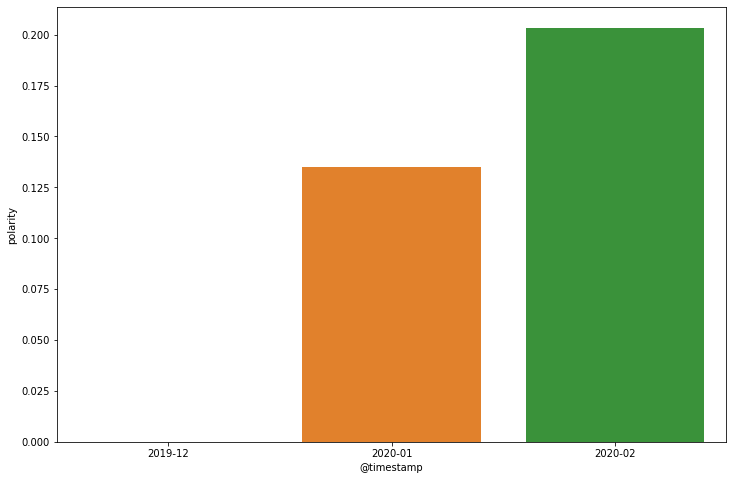

In [54]:
fig_dims = (12,8)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(x = '@timestamp', y = 'polarity', ax=ax, data=avg_dataframe2)

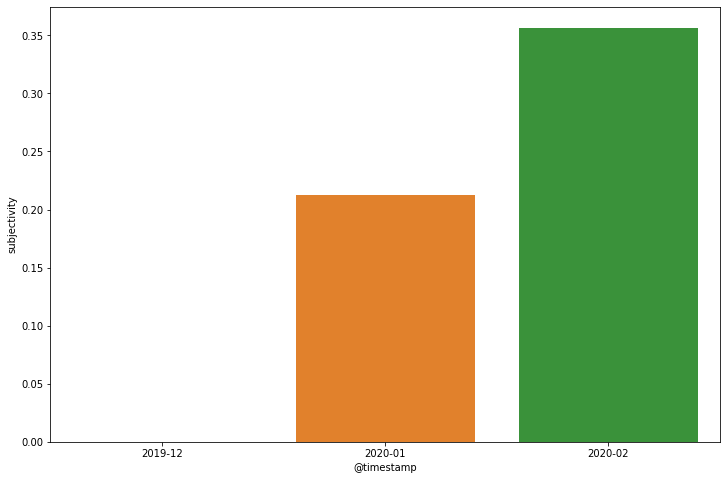

In [55]:
fig_dims = (12,8)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(x = '@timestamp', y = 'subjectivity', ax=ax, data=avg_dataframe2)

In [56]:
unique_rating = finalData["edata_rating"].unique()
print(unique_rating)


[1. 2. 3. 4. 5.]


In [57]:
mean_polarity = list(finalData.groupby('edata_rating').polarity.mean())
mean_polarity

[-0.007337031900138699,
 0.029901960784313716,
 0.10595959595959598,
 0.1896734234234234,
 0.26017394822006495]

In [58]:
mean_subjectivity = list(finalData.groupby('edata_rating').subjectivity.mean())
mean_subjectivity

[0.20300624133148404,
 0.1492156862745098,
 0.13646464646464646,
 0.23265765765765764,
 0.34001618122977334]

In [59]:
average_rating = list(zip(unique_rating,mean_polarity,mean_subjectivity))
print(average_rating)

[(1.0, -0.007337031900138699, 0.20300624133148404), (2.0, 0.029901960784313716, 0.1492156862745098), (3.0, 0.10595959595959598, 0.13646464646464646), (4.0, 0.1896734234234234, 0.23265765765765764), (5.0, 0.26017394822006495, 0.34001618122977334)]


In [60]:
avg_dataframe=pd.DataFrame(average_rating, columns=["edata_rating","polarity","subjectivity"])
avg_dataframe

,edata_rating,polarity,subjectivity
0,1.0,-0.007337,0.203006
1,2.0,0.029902,0.149216
2,3.0,0.105960,0.136465
3,4.0,0.189673,0.232658
4,5.0,0.260174,0.340016


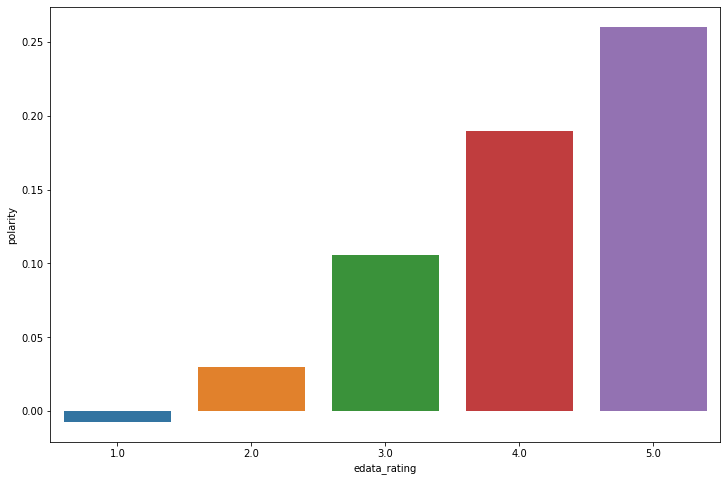

In [61]:
fig_dims = (12,8)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(x = 'edata_rating', y = 'polarity', ax=ax, data=avg_dataframe)

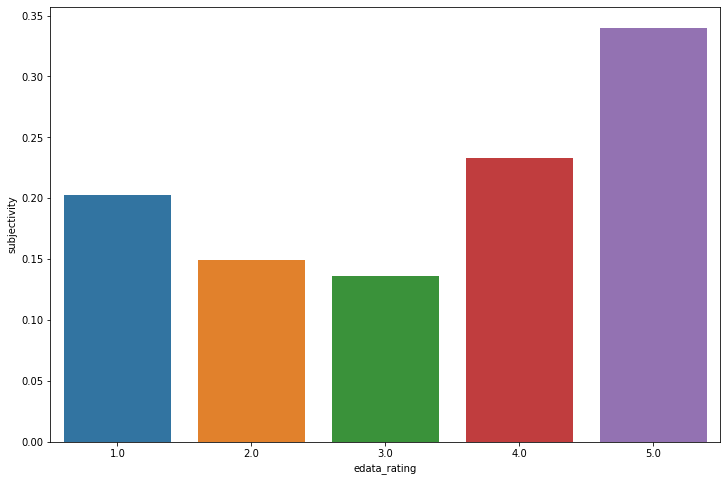

In [62]:
fig_dims = (12,8)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(x = 'edata_rating', y = 'subjectivity', ax=ax, data=avg_dataframe)

In [63]:
finalData.to_csv ('/Users/tanyachauhan/Documents/Diksha_content_data.csv', index = False, header=True)
finalData

,index,edata_rating,edata_comments,Keywords,object_id,@timestamp,polarity,subjectivity
0,0,1.0,R,[],do_31251881421707673619722,2019-12,0.000000,0.000000
1,123,1.0,slow sounds,[slow sounds],do_31291958253234585612069,2020-01,-0.300000,0.400000
2,330,1.0,Very very very bad,[bad],do_312956205131456512144,2020-02,-0.910000,0.866667
3,327,1.0,aka,[aka],do_312956205131456512144,2020-02,0.000000,0.000000
4,133,1.0,gdjf,[gdjf],do_31292027941115494412474,2020-01,0.000000,0.000000
...,...,...,...,...,...,...,...,...
391,165,5.0,��ಮ�ಮ� ���൮ಮ��,[],do_31251881421707673619722,2020-02,0.000000,0.000000
392,162,5.0,nice,[nice],do_31291802222771404811686,2020-02,0.600000,1.000000
393,160,5.0,rt,[rt],do_31251881421707673619722,2020-02,0.000000,0.000000
394,173,5.0,VERY SUPER,[super],do_31292027941115494412474,2020-02,0.433333,0.866667


In [64]:
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 


In [65]:
comment_words = ' '
stopwords = set(STOPWORDS) 

In [66]:
# for i in unique_month:
#     for j in finalData["@timestamp"]:
#         if(i==j):
reviewdf = list(finalData.groupby('@timestamp').Keywords)
reviewdf[0][1]
reviewdf = finalData["Keywords"]
reviewdf
comment_words = ' '
stopwords = set(STOPWORDS) 
for val in reviewdf: 
    val = str(val) 

# split the value 
tokens = val.split() 

# Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 

    for words in tokens: 
        comment_words = comment_words + words + ' '


wordcloud = WordCloud(width = 800, height = 800, 
background_color = 'black', 
stopwords = stopwords, 
min_font_size = 10).generate(comment_words) 

plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

plt.show() 


IndentationError: unexpected indent (<ipython-input-66-959900415d0f>, line 17)

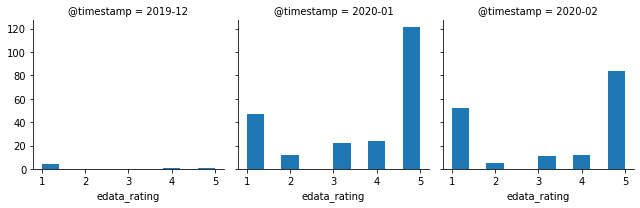

In [67]:
g = sns.FacetGrid(finalData,col="@timestamp")
g.map(plt.hist,"edata_rating")
plt.show()

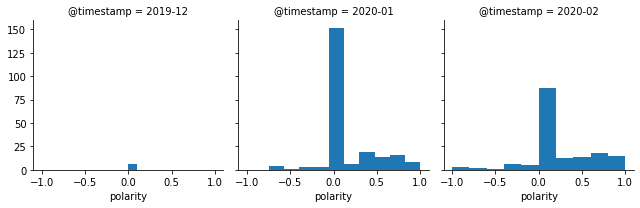

In [68]:
g = sns.FacetGrid(finalData,col="@timestamp")
g.map(plt.hist,"polarity")
plt.show()

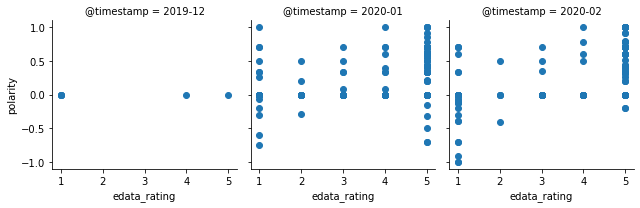

In [69]:
g = sns.FacetGrid(finalData,col="@timestamp")
g.map(plt.scatter,"edata_rating","polarity")
plt.show()